In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.decomposition.asf import ASF
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.optimization.saver import load_checkpoint
from auto_robot_design.description.builder import jps_graph2pinocchio_robot


In [2]:
import tkinter as tk
from tkinter import filedialog

def select_directory():
    # Create a root window
    root = tk.Tk()
    # Hide the root window
    root.withdraw()
    # Make the root window the topmost window
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Open directory dialog and store the selected directory path
    directory_path = filedialog.askdirectory(initialdir="./",
        title="Select a directory"
    )
    root.update_idletasks() 
    root.destroy()
    # Check if a directory was selected
    if directory_path:
        #print(f"Selected directory: {directory_path}")
        return directory_path
    else:
        #print("No directory selected")
        return None

# Call the function to open the directory dialog
selected_directory = select_directory()
print(f"Resulting directory path: {selected_directory}")

Resulting directory path: D:/work/projects/mechanism_builder/apps/optimize/results/first_setup/topology_0_2024-09-15_23-56-09


In [3]:
problem = MultiCriteriaProblem.load(
    selected_directory
)

checkpoint = load_checkpoint(selected_directory)
optimizer = PymooOptimizer(problem, checkpoint)
optimizer.load_history(selected_directory)
res = optimizer.run()

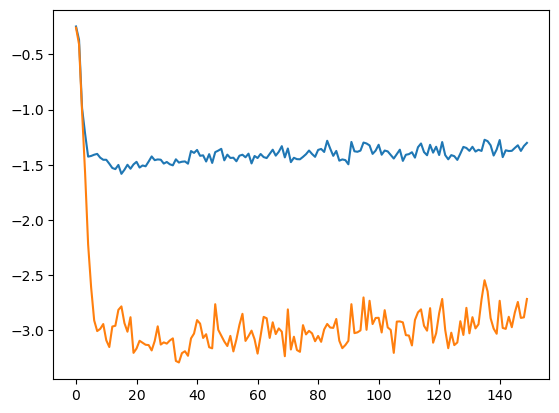

In [4]:
history_mean = optimizer.history["Mean"]
plt.plot(np.arange(len(history_mean)), history_mean)
plt.show()


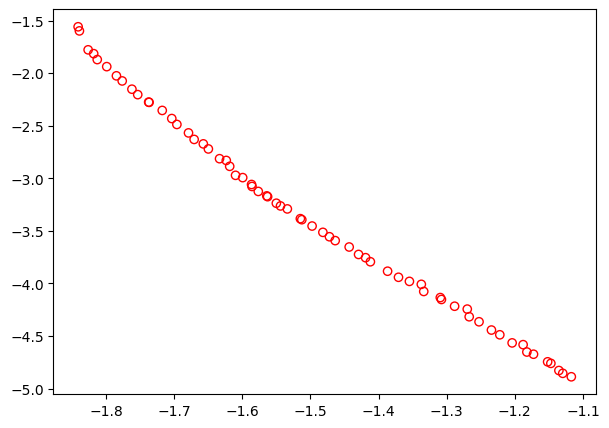

In [5]:
F = res.F
xl, xu = problem.bounds()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, )
ax.scatter(F[:, 0], F[:, 1],  facecolors='none', edgecolors='r')

In [6]:
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)


Scale f1: [-1.8407769600550334, -1.1171908775965373]
Scale f2: [-4.887489634301626, -1.5591049599654134]


Best regarding ASF: 
F = [-1.44309624 -3.65336136]


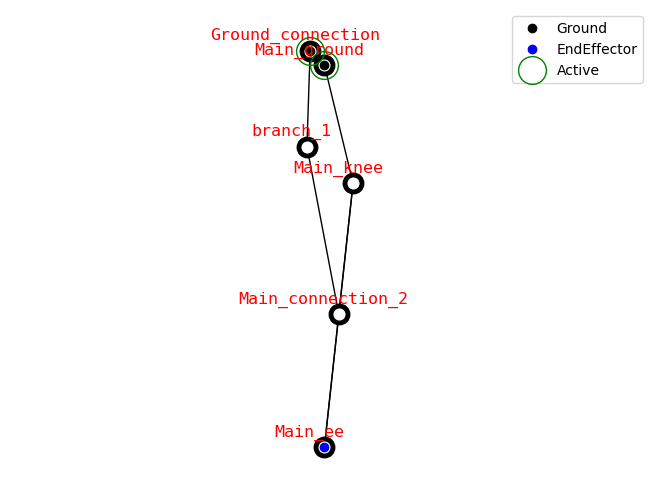

In [7]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.4, 0.6])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]
print(f"Best regarding ASF: \nF = {F[b]}")
graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)

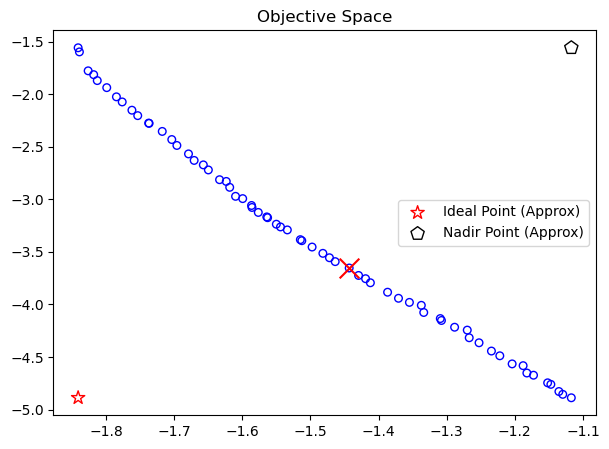

In [8]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none', edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none', edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.scatter(F[b, 0], F[b, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.legend()
plt.show()

In [9]:
histF = np.array(optimizer.history["F"])
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 0.9275


In [10]:
worstF1_id = np.argmax(validF1)
worstF2_id = np.argmax(validF2)
worst_reward2 = validF2[worstF2_id]
worst_reward1 = validF1[worstF1_id]
print('The maximum result in optimization task:', worst_reward1, worst_reward2)

The maximum result in optimization task: -0.8837439219156901 -0.635128341215092


In [11]:
bestF1_id = np.argmin(validF1)
bestF2_id = np.argmin(validF2)
bestF1_x = optimizer.history["X"][np.where(histF[:,0]==validF1[bestF1_id])[0][0]]
bestF1_reward = validF1[bestF1_id]
bestF2_x = optimizer.history["X"][np.where(histF[:,1]==validF2[bestF2_id])[0][0]]
bestF2_reward = validF2[bestF2_id]
print("The minimum result in optimization task: F1:", bestF1_reward, " F2: ", bestF2_reward, f" F: weights: {weights}", F[b])

The minimum result in optimization task: F1: -1.8407769600550334  F2:  -4.887489634301626  F: weights: [0.4 0.6] [-1.44309624 -3.65336136]


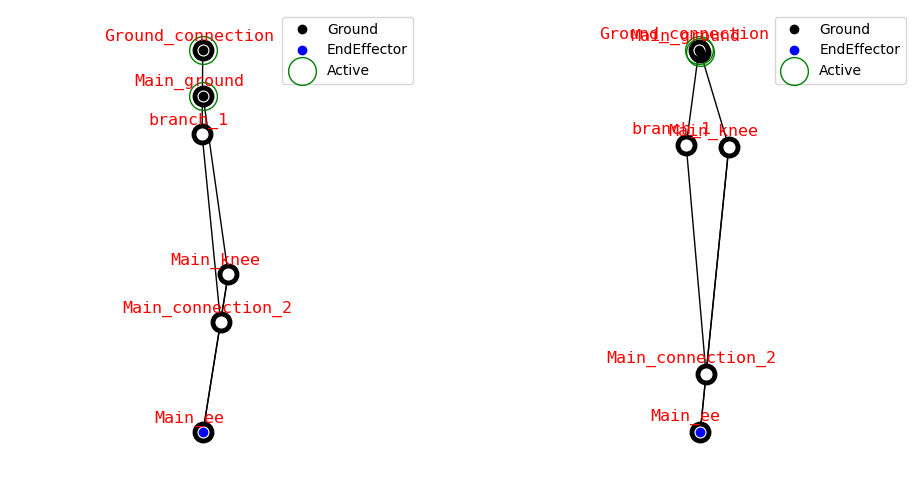

In [12]:
gm = problem.graph_manager
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
graph = gm.get_graph(bestF1_x)
draw_joint_point(graph)
plt.subplot(1, 3, 2)
graph = gm.get_graph(bestF2_x)
draw_joint_point(graph)


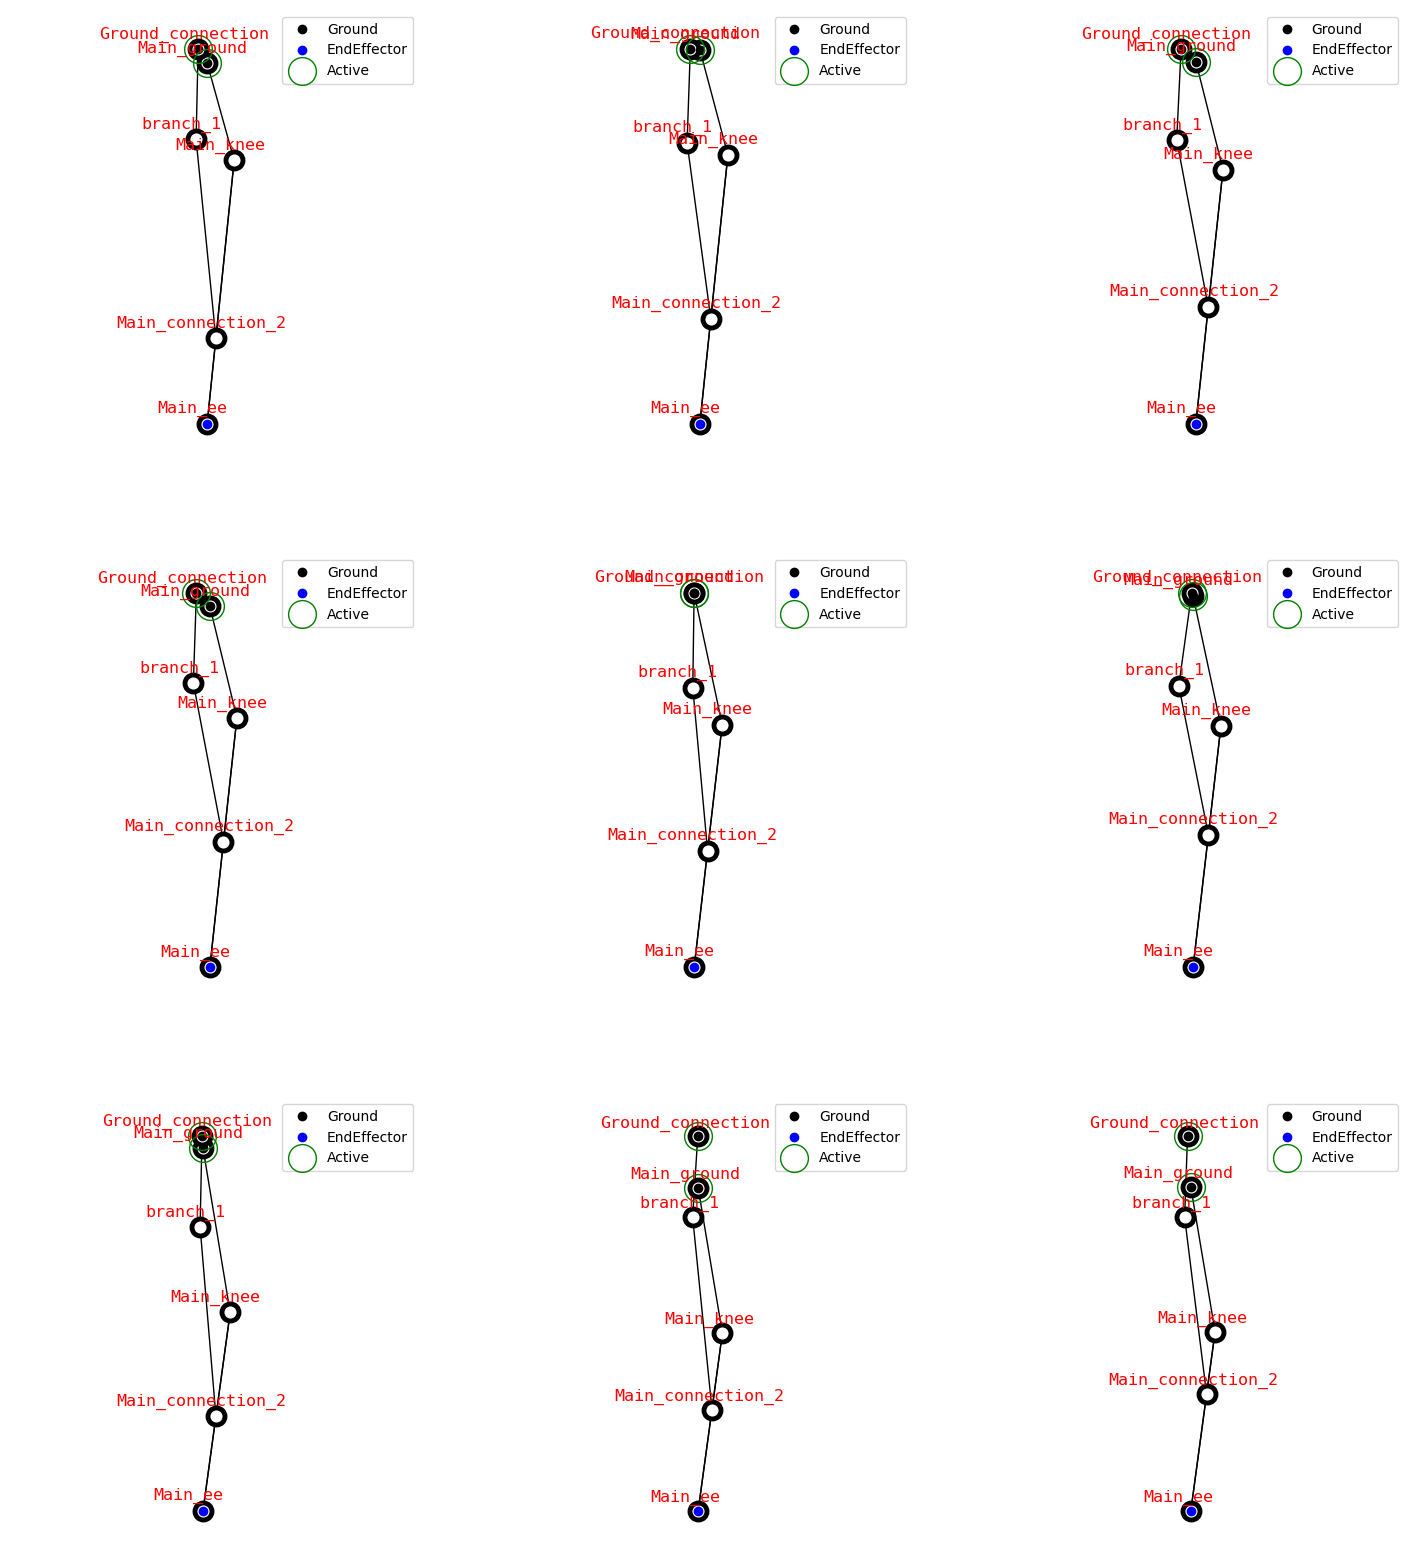

In [13]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
decomp = ASF()
weights_vector = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(18, 20))
for i, w in enumerate(weights_vector):
    weights = np.array([w, 1-w])
    b = decomp.do(nF, 1/weights).argmin()
    best_x = res.X[b]
    graph = problem.graph_manager.get_graph(best_x)
    plt.subplot(3, 3, i+1)
    draw_joint_point(graph)

plt.show()

In [14]:
histF = res.F
validF1 = histF[:,0][histF[:,0]<0]
validF2 = histF[:,1][histF[:,1]<0]
print('Percentage of valid mechanisms:', len(validF1)/len(histF))

Percentage of valid mechanisms: 1.0


In [15]:
len(res.F)

64

In [16]:
# from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
# thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
# actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
# density = MIT_CHEETAH_PARAMS_DICT["density"]
# body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


# builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
#                               density={"default": density, "G": body_density},
#                               thickness={"default": thickness, "EE": 0.033},
#                               actuator={"default": actuator},
#                               size_ground=np.array(
#                                   MIT_CHEETAH_PARAMS_DICT["size_ground"]),
#                               offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
#                               )

# from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
# from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
# from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
# from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
# from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability

# ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50))

# ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50))

# ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50))


# central_vertical = convert_x_y_to_6d_traj_xz(
#     *get_vertical_trajectory(-0.32, 0.075, 0, 50))

# left_vertical = convert_x_y_to_6d_traj_xz(
#     *get_vertical_trajectory(-0.32, 0.065, -0.09, 50))

# right_vertical = convert_x_y_to_6d_traj_xz(
#     *get_vertical_trajectory(-0.32, 0.065, 0.09, 50))
# # 2) characteristics to be calculated
# # criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
# dict_trajectory_criteria = {
#     "MASS": NeutralPoseMass(),
# }
# # criteria calculated for each point on the trajectory
# dict_point_criteria = {
#     "Effective_Inertia": EffectiveInertiaCompute(),
#     "Actuated_Mass": ActuatedMass(),
#     "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
# }
# # special object that calculates the criteria for a robot and a trajectory
# crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# # set the rewards and weights for the optimization task
# acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
#                                                     trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

# heavy_lifting = HeavyLiftingReward(
#     manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# # set up special classes for reward calculations
# error_calculator = PositioningErrorCalculator(
#     error_key='error', jacobian_key="Manip_Jacobian")
# # soft_constrain = PositioningConstrain(
# #     error_calculator=error_calculator, points=[workspace_trajectory])
# sf = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
#                                                                                    ground_symmetric_step2,
#                                                                                    ground_symmetric_step3,
#                                                                                    central_vertical,
#                                                                                    left_vertical,
#                                                                                    right_vertical])

# # manager should be filled with trajectories and rewards using the manager API
# reward_manager = RewardManager(crag=crag)
# reward_manager.add_trajectory(ground_symmetric_step1, 0)
# reward_manager.add_trajectory(ground_symmetric_step2, 1)
# reward_manager.add_trajectory(ground_symmetric_step3, 2)

# reward_manager.add_trajectory(central_vertical, 3)
# reward_manager.add_trajectory(left_vertical, 4)
# reward_manager.add_trajectory(right_vertical, 5)

# reward_manager.add_reward(acceleration_capability, 0, 1)
# reward_manager.add_reward(acceleration_capability, 1, 1)
# reward_manager.add_reward(acceleration_capability, 2, 1)

# reward_manager.add_reward(heavy_lifting, 3, 1)
# reward_manager.add_reward(heavy_lifting, 4, 1)
# reward_manager.add_reward(heavy_lifting, 5, 1)

# reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
# reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

In [17]:
import pinocchio as pin
pin.seed(3)
sf = problem.soft_constrain
builder = problem.builder
crag = problem.rewards_and_trajectories.crag
# trajectory = problem.rewards_and_trajectories.trajectories[1]

counter = 0
for i, x in enumerate(res.X):
    x= np.round(x, 4)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    
    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter += 1
    else:
        __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
        print(res.F[i], vector_rewards)
counter

[-1.22209636 -4.48817525] [1.22209636370341, 4.488175253224335]
[-1.75334167 -2.20435783] [1.7534308830897014, 2.2043579066235965]
[-1.13539267 -4.82788147] [1.1353938579559326, 4.827882149591074]
[-1.5147326  -3.38386447] [1.5147325992584229, 3.3838644691213524]
[-1.1824009  -4.65200619] [1.182400902112325, 4.652006192163859]
[-1.65709559 -2.67271571] [1.6570955912272136, 2.672715706530267]
[-1.62342385 -2.83013038] [1.6234238545099895, 2.8301303788550545]
[-1.49751059 -3.45399103] [1.497484604517619, 3.453991381804535]
[-1.84077696 -1.55910496] [1.8407769600550334, 1.5591049599654134]
[-1.11719088 -4.88748963] [1.1171908775965373, 4.887489634301626]
[-1.17264855 -4.67290234] [1.172648549079895, 4.672902343031099]
[-1.71736681 -2.35459676] [1.7173668146133423, 2.354596759944545]
[-1.2525684  -4.36445047] [1.2525684038798015, 4.364450467466653]
[-1.12975025 -4.85468569] [1.1297502517700195, 4.854685687252885]
[-1.30773381 -4.15237328] [1.3077338139216106, 4.152373278068178]
[-1.7845928

0

In [18]:
F = np.array(optimizer.history["F"])
X = np.array(optimizer.history["X"])
Fs = np.array(optimizer.history["Fs"])
idx=np.where(F[:,0]==res.F[0][0])[0][0]
idx

8087

In [19]:
x = X[idx]
x

array([-0.0118823 ,  0.0145157 , -0.11123178, -0.00032957, -0.18225723,
       -0.0009649 , -0.10045527])

In [20]:
Fs[idx]

array([1.15202188, 1.22937584, 1.28489137, 6.379024  , 3.49092999,
       3.59457177])

In [21]:
x = np.round(X[idx],4)
print(x)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
#point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

if constrain_error>0:
    print(constrain_error)
    counter+=1
#else:
__, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
print(F[idx], vector_rewards, '\n', partial_rewards)

[-0.0119  0.0145 -0.1112 -0.0003 -0.1823 -0.001  -0.1005]
[-1.22209636 -4.48817525] [1.22209636370341, 4.488175253224335] 
 [1.1520219, 1.2293758, 1.2848914, 6.379023995724737, 3.4909299929284847, 3.594571771019783]


In [22]:
for i in range(3,8):    
    x = np.round(X[idx],i)
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.2186518510182698, 4.505313431503308] 
 [1.1479262, 1.2260064, 1.282023, 6.414368438670408, 3.5039447882556582, 3.597627067583856]
[1.22209636370341, 4.488175253224335] 
 [1.1520219, 1.2293758, 1.2848914, 6.379023995724737, 3.4909299929284847, 3.594571771019783]
[1.222073237101237, 4.488457063825466] 
 [1.1519948, 1.2293515, 1.2848734, 6.38010219533159, 3.491308616701303, 3.5939603794435047]
[1.2220571438471477, 4.488475096976759] 
 [1.1519754, 1.2293358, 1.2848603, 6.380053089060312, 3.491443439694234, 3.593928762175732]
[1.222057819366455, 4.4884695122975815] 
 [1.151976, 1.2293365, 1.284861, 6.380034827984703, 3.491441611453464, 3.593932097454576]


In [23]:
import random 
for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 

In [24]:
import random 
for i in range(8): 
    np.random.seed = i
    random.seed = i
    x = X[idx]
    graph = gm.get_graph(x)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
    #point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

    constrain_error, results = sf.calculate_constrain_error(crag, fixed_robot, free_robot)

    if constrain_error>0:
        print(constrain_error)
        counter+=1
    #else:
    __, partial_rewards, vector_rewards = problem.rewards_and_trajectories.calculate_total(fixed_robot, free_robot, problem.motor)
    print(vector_rewards, '\n', partial_rewards)

[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 6.38003706048118, 3.491442729213833, 3.593932366474507]
[1.2220575014750164, 4.488470718723173] 
 [1.1519755, 1.2293363, 1.2848607, 

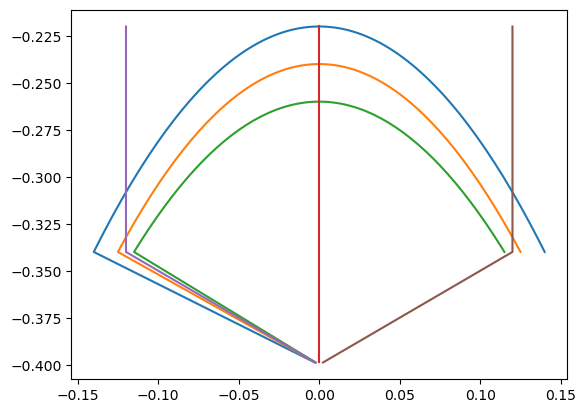

In [26]:
for _, trajectory in problem.rewards_and_trajectories.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])


plt.show()

In [27]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat
trajectory = problem.rewards_and_trajectories.trajectories[5]
x= np.round(X[idx],4)
graph = gm.get_graph(x)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
crag.get_criteria_data(fixed_robot, free_robot, trajectory,50,viz)
#calculate_quasi_static_simdata(free_robot, fixed_robot,'EE', trajectory, viz=viz)
pass

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/
